# **Classifying Stack Overflow Questions: Multiclass classification**

### Imports

In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

### Reading in the Stack Overflow raw data

In order to build a robust classifier, any occurences of the words Python, CSharp, JavaScript, or Java in the programming questions have been replaced with the word "blank" (as many questions contain the language they're about) in this dataset.



In [3]:
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"


tf.keras.utils.get_file("/content/stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')



6053888/6053168 [==============================] - 0s 0us/step


'/content/stack_overflow_16k'

In [4]:
os.listdir()

['.config',
 'test',
 'stack_overflow_16k.tar.gz',
 'train',
 'README.md',
 'sample_data']

The folders in /train directory are: csharp, python, java, javascript. These are the 4 classes. 

In [5]:
train_dir = "/content/train"
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

Viewing a sample file in the train/python directory

In [6]:
sample_file = os.path.join(train_dir, 'python/0.txt')
with open(sample_file) as f:
  print(f.read())

"is it legal to define two methods with the same name but different returning types? i've written a piece of code to determine a typical palindrome string. i did this by the definition of a reverse() method returning a string. i also eager to have the same method, but in the void form, because of some future needs..as i add the latter to the code, the valid output will become invalid..so, the question is that is it legal to define two methods with the same name but different returning types?.if not, please let me know how to write this code with the void-type method...class detector(object):.    def __init__(self,string):.        self.string = string..    forbidden = (' ','!','?','.','-','_','&amp;','%',""#"","","")..    def eliminator(self):.        for item in self.forbidden:.            if item in self.string:.                self.string = self.string.replace(item,"""")..    def reverse(self):.        return self.string[::-1]            ..    #def reverse(self):.    #    self.string

### Loading the dataset

In [7]:
batch_size = 32
seed = 29

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [9]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [10]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [11]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


### Data Preprocessing


In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize= 'lower_and_strip_punctuation',
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [15]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [16]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [36]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question", first_question)
print("Language", raw_train_ds.class_names[first_label])
print("Vectorized Question", vectorize_text(first_review, first_label))

Question tf.Tensor(b'"where do i find the blank standard library code? i wanted to try and look up the source of some of the modules in the blank standard library, but wasn\'t able to find them. i tried looking in the modules directory after downloading the blank tarball, but it has mainly .c files. i also tried looking at the directory where the blank that already comes with the os (mac osx) has it\'s modules, and there it seems to have mainly .pyc and .pyo files. would really appreciate it if someone can help me out...(i tried what was suggested in the question how do i find the location of blank module sources? with no luck)"\n', shape=(), dtype=string)
Language python
Vectorized Question (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  25,    4,  209,    5,  116,   42,  105,  404,   32,    5,   42,
           3,   35,  696,    4,   26,    5,  404,  136,  120,  212,    6,
           5, 2931,   57,    8,  120,   50,    6,    5,   56,   22,  562,
         337,    7,   13,  2

In [37]:
print("25 ---> ",vectorize_layer.get_vocabulary()[25])
print(" 4 ---> ",vectorize_layer.get_vocabulary()[4])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

25 --->  how
 4 --->  to
Vocabulary size: 10000


In [38]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [39]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Building the model

In [40]:
embedding_dim = 16

In [41]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics= ['accuracy'])

### Training the model

In [43]:
epochs = 20
history = model.fit(train_ds,validation_data=val_ds,epochs= epochs)

Epoch 1/20
200/200 [==============================] - 4s 17ms/step - loss: 1.3828 - accuracy: 0.2993 - val_loss: 1.3699 - val_accuracy: 0.3794
Epoch 2/20
200/200 [==============================] - 1s 5ms/step - loss: 1.3597 - accuracy: 0.4282 - val_loss: 1.3345 - val_accuracy: 0.4444
Epoch 3/20
200/200 [==============================] - 1s 6ms/step - loss: 1.3151 - accuracy: 0.5000 - val_loss: 1.2792 - val_accuracy: 0.5194
Epoch 4/20
200/200 [==============================] - 1s 5ms/step - loss: 1.2499 - accuracy: 0.5639 - val_loss: 1.2114 - val_accuracy: 0.5688
Epoch 5/20
200/200 [==============================] - 1s 5ms/step - loss: 1.1716 - accuracy: 0.6188 - val_loss: 1.1403 - val_accuracy: 0.6200
Epoch 6/20
200/200 [==============================] - 1s 6ms/step - loss: 1.0902 - accuracy: 0.6754 - val_loss: 1.0727 - val_accuracy: 0.6506
Epoch 7/20
200/200 [==============================] - 1s 6ms/step - loss: 1.0131 - accuracy: 0.7072 - val_loss: 1.0119 - val_accuracy: 0.6869
Epoch

### Evaluate the model

In [44]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 3s 11ms/step - loss: 0.6337 - accuracy: 0.7807
Loss:  0.6337040066719055
Accuracy:  0.7807499766349792


In [45]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

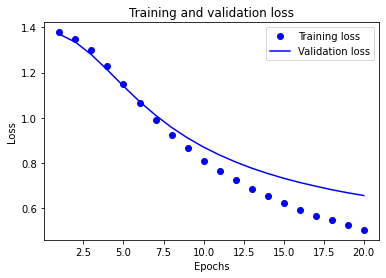

In [46]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

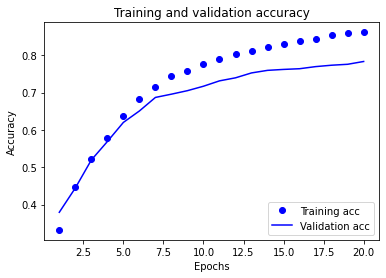

In [47]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Exporting the model

In [48]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 3s 11ms/step - loss: 0.6254 - accuracy: 0.7857
0.7807499766349792


### Inference on new data

In [49]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [54]:
example = [
  "def add(num): for i in range(len(n) .py file print() i += 1", ##python
  "var legalArray = [4, undefined, ""];", ##javascript
 
  

  
]

export_model.predict(example)

array([[0.40035713, 0.447245  , 0.39484215, 0.7323151 ],
       [0.5046397 , 0.38052762, 0.7417691 , 0.39581048]], dtype=float32)